# Original image load and visualization

In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.9 MB/s eta 0:00:0000:01


In [2]:
import os
import pydicom
from PIL import Image
import shutil
import cv2
import torch
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import matplotlib.image as mpimg
import random
from keras.utils import to_categorical
from concurrent.futures import ThreadPoolExecutor
from glob import glob

In [3]:
!pip install --upgrade openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.3
    Uninstalling openpyxl-3.0.3:
      Successfully uninstalled openpyxl-3.0.3


In [4]:
dicom_data = pd.read_csv('all_mass_pathology.csv')

In [5]:
dicom_data.head(2)

,patient_id,pathology,image file path,cropped image file path,ROI mask file path,crop_name,ROI_name,full_name,ROI number,Crop number
0,P_00001,MALIGNANT,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1,Mass-Training_P_00001_LEFT_CC_1,Mass-Training_P_00001_LEFT_CC,1,0
1,P_00001,MALIGNANT,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1,Mass-Training_P_00001_LEFT_MLO_1,Mass-Training_P_00001_LEFT_MLO,1,0


In [6]:
# Specify the root path where the .png files are located
jpg_root_path = 'content/all_598_augmented'

# Function to get all .png file paths in a directory
def get_jpg_file_paths(directory):
    jpg_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png'):
                jpg_paths.append(os.path.join(root, file))
    return jpg_paths

# Get all .png file paths under the specified directory
jpg_paths = get_jpg_file_paths(jpg_root_path)

# Create a DataFrame with the file paths
df = pd.DataFrame({'File_Paths': jpg_paths})

In [7]:
# Extracting the information from the file paths and matching with dicom_data
df['ID1'] = df['File_Paths'].apply(lambda x: x.split('/')[-1] if len(x.split('/')) > 1 else '')

In [8]:
dicom_data['ID1'] = dicom_data['image file path'].apply(lambda x: x.split('/')[-4] if len(x.split('/')) > 1 else '')

In [9]:
# Assuming unique_df and jpg_paths_df are your DataFrames
for index, row in dicom_data.iterrows():
    # Check if 'image_file_path_first_part' is in 'image_file_path' of jpg_paths_df
    mask = df['ID1'].str.contains(row['ID1'])

    # If there is a match, update 'pathology' in jpg_paths_df
    df.loc[mask, 'pathology'] = row['pathology']
    # df.loc[mask, 'full_image_name'] = row['image_file_path_first_part']

In [10]:
df.dropna(subset=['pathology'], inplace=True)

In [11]:
len(df)

10176

In [12]:
df.head(2)

,File_Paths,ID1,pathology
0,content/all_598_augmented/_content_roi_train_M...,_content_roi_train_Mass-Training_P_00517_LEFT_...,BENIGN_WITHOUT_CALLBACK
1,content/all_598_augmented/_content_roi_train_M...,_content_roi_train_Mass-Training_P_01149_RIGHT...,MALIGNANT


In [13]:
df['pathology'].value_counts()

MALIGNANT                  4740
BENIGN                     4590
BENIGN_WITHOUT_CALLBACK     846
Name: pathology, dtype: int64

Randomly Picked Images:



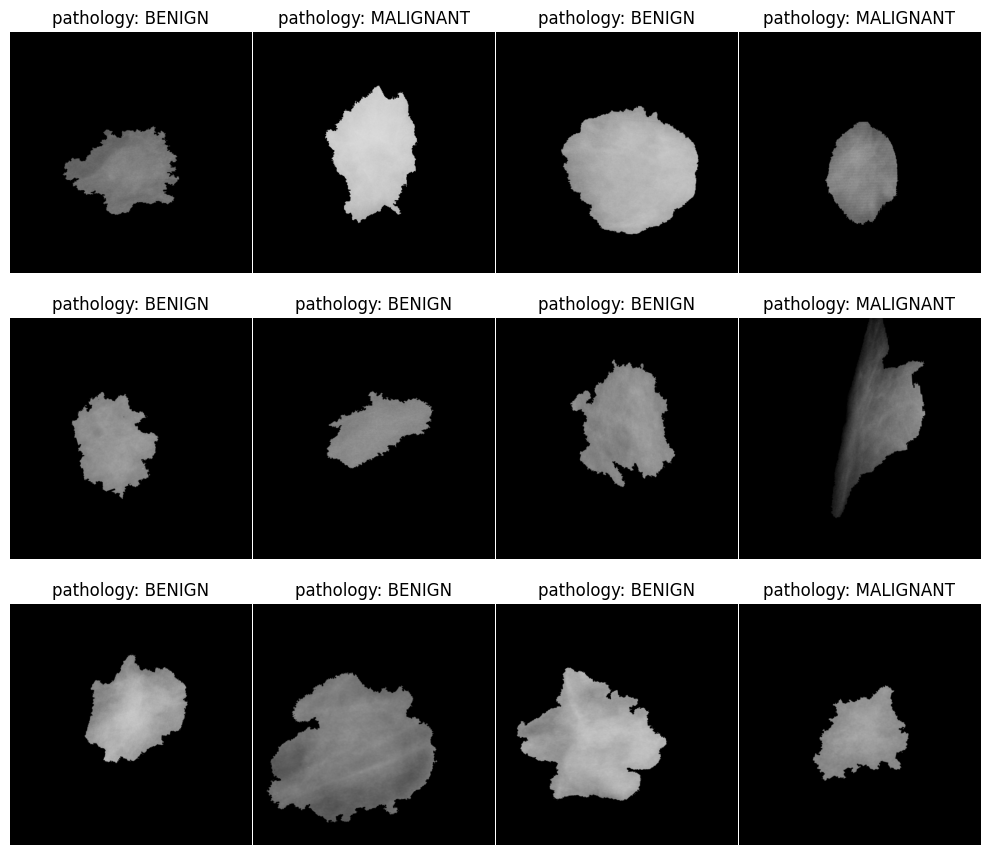

In [14]:
# # create function to display images
# # deleted not in usage
# def display_images(dataframe, number, rows, cols, save_path=None):
#     """displays images in the dataset"""
#     # create figure and axes with reduced spacing
#     fig, axes = plt.subplots(rows, cols, figsize=(10, 10), tight_layout={'w_pad': 0.1, 'h_pad': 0.1})

#     # Get a random sample of indices
#     random_indices = random.sample(range(len(dataframe)), number)

#     # Loop through rows and display images
#     for row_index in range(rows):
#         for col_index in range(cols):
#             index = row_index * cols + col_index
#             if index < number:  # Check if there are still images to display
#                 row = dataframe.iloc[random_indices[index]]
#                 image_path = row['File_Paths']

#                 # Check if image path is not missing and file exists
#                 if pd.notna(image_path) and os.path.exists(image_path):
#                     image = cv2.imread(image_path)
#                     ax = axes[row_index, col_index]
#                     ax.imshow(image, cmap='gray')
#                     ax.set_title(f"pathology: {row['pathology']}")
#                 else:
#                     # Placeholder for missing image
#                     ax = axes[row_index, col_index]
#                     ax.text(0.5, 0.5, "Missing Image", ha='center', va='center', fontsize=10, color='red')

#                 ax.axis('off')

#     # Save the figure in PDF format with 1000 dpi
#     if save_path:
#         plt.savefig(save_path, dpi=1000, format='pdf')

#     plt.show()

# # Display and save 12 randomly picked images
# print('Randomly Picked Images:\n')
# display_images(df, 12, 3, 4, save_path='randomly_picked_images.pdf')

# process and model construction

In [15]:
pip install tensorflow-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 50.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.9/311.9 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 55.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully un

In [16]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
#another model option
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Define the additional convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Change input channels to 1
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.1),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.1),
            nn.Conv2d(4, 3, kernel_size=1),
            # nn.BatchNorm2d(3),
            nn.LeakyReLU(0.1)
        )
        
        # Load the pretrained Xception model
        self.feature_extractor = timm.create_model('legacy_xception', pretrained=True)
        
        # Remove the last two layers of the Xception model
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
        
        # Add the desired layers
        self.global_pooling = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc1 = nn.Linear(2048, 512)
        self.relu = nn.ReLU()  # Changed LeakyReLU to ReLU
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Forward pass through the convolutional layers
        x = self.conv_layers(x)
        
        # Forward pass through the feature extractor
        x = self.feature_extractor(x)
        
        # Forward pass through the added layers
        x = self.global_pooling(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Moved dropout after ReLU in fc2
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x

# Create an instance of the model
model = CustomModel()

# Print model summary
print(model)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


CustomModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.1)
    (10): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.1)
    (13): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
    (14

In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Map labels to binary values
label_mapping = {'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0, 'MALIGNANT': 1}
df['label'] = df['pathology'].map(label_mapping)

In [19]:
df.head(2)

,File_Paths,ID1,pathology,label
0,content/all_598_augmented/_content_roi_train_M...,_content_roi_train_Mass-Training_P_00517_LEFT_...,BENIGN_WITHOUT_CALLBACK,0
1,content/all_598_augmented/_content_roi_train_M...,_content_roi_train_Mass-Training_P_01149_RIGHT...,MALIGNANT,1


In [20]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]  # Assuming the image paths are in the first column
        image = Image.open(img_name)
        label = self.data.iloc[idx, 3]  # Assuming the labels are in the second column
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Lambda(lambda x: x / 65535.0),  # Normalize tensor by dividing by 65535.0

])

In [21]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)

# Split the train set into train and validation sets
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

# Create datasets and dataloaders for train, validation, and test sets
train_dataset = CustomDataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = CustomDataset(val_data, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # No need to shuffle validation data

test_dataset = CustomDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # No need to shuffle test data

In [22]:
import os
import torch

# Print one example shape and labels
images, labels = next(iter(train_loader))
print("Data loader batch shape - images:", images.shape, "labels:", labels.shape)

# print the input size
input_example = torch.randn(16, 1, 598, 598)  # Create an example input
model = CustomModel()
model.to("cuda")  # Move the model to GPU
output_example = model(input_example.cuda())
print("Model input shape:", input_example.shape, "output shape:", output_example.shape)

Data loader batch shape - images: torch.Size([16, 1, 598, 598]) labels: torch.Size([16])
Model input shape: torch.Size([16, 1, 598, 598]) output shape: torch.Size([16, 1])


In [23]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss()  # Use binary cross-entropy loss function since the labels are binary
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer, which automatically adjusts the learning rate

# Move the model and data to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 40

for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Inside the training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs.squeeze(), labels.float())  # Squeeze to remove extra dimension

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        predicted_labels = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification
        predicted_labels_int = predicted_labels.view(-1).long()
        total_correct += (predicted_labels_int == labels).sum().item()
        total_samples += labels.size(0)
          
    # Calculate accuracy and loss for training set
    train_accuracy = total_correct / total_samples
    train_loss = running_loss / len(train_loader)
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0
    
    with torch.no_grad():  # No need to calculate gradients during validation
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move data to GPU

            # Forward pass
            val_outputs = model(val_images)

            # Calculate loss
            val_loss = criterion(val_outputs.squeeze(), val_labels.float())  # Squeeze to remove extra dimension
            val_running_loss += val_loss.item()

            # Calculate accuracy
            val_predicted_labels = (val_outputs > 0.5).float()  # Threshold at 0.5 for binary classification
            val_predicted_labels_int = val_predicted_labels.view(-1).long()
            val_total_correct += (val_predicted_labels_int == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate accuracy and loss for validation set
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_running_loss / len(val_loader)

    # Print the training and validation results for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Save model checkpoints for the last 10 epochs
    if epoch >= num_epochs - 10:
        checkpoint_name = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), checkpoint_name)
        print(f"Checkpoint saved: {checkpoint_name}")

Epoch [1/40], Training Loss: 0.6784, Training Accuracy: 0.5769, Validation Loss: 0.6519, Validation Accuracy: 0.6118
Epoch [2/40], Training Loss: 0.6599, Training Accuracy: 0.6128, Validation Loss: 0.8029, Validation Accuracy: 0.5823
Epoch [3/40], Training Loss: 0.6449, Training Accuracy: 0.6333, Validation Loss: 0.6498, Validation Accuracy: 0.6172
Epoch [4/40], Training Loss: 0.6223, Training Accuracy: 0.6507, Validation Loss: 0.6540, Validation Accuracy: 0.6600
Epoch [5/40], Training Loss: 0.6051, Training Accuracy: 0.6729, Validation Loss: 0.5628, Validation Accuracy: 0.7135
Epoch [6/40], Training Loss: 0.5889, Training Accuracy: 0.6885, Validation Loss: 0.5477, Validation Accuracy: 0.7170
Epoch [7/40], Training Loss: 0.5487, Training Accuracy: 0.7234, Validation Loss: 0.6609, Validation Accuracy: 0.7091
Epoch [8/40], Training Loss: 0.5177, Training Accuracy: 0.7455, Validation Loss: 0.5676, Validation Accuracy: 0.7155
Epoch [9/40], Training Loss: 0.4608, Training Accuracy: 0.7827, 

In [24]:
print("Done")

Done


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# # Assuming you have defined your device as 'cuda' if available, else 'cpu'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the best model state dictionary
model.load_state_dict(torch.load('model_epoch_37.pth'))

# Set the model to evaluation mode
model.eval()

# Send the model to the same device as the input data
# model.to(device)

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Loop through the test dataset
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        # Forward pass
        outputs = model(test_images)

        # Calculate predicted probabilities
        predicted_probs.extend(outputs.cpu().numpy())

        # Convert labels to numpy array and append to true_labels list
        true_labels.extend(test_labels.cpu().numpy())

# Convert true_labels and predicted_probs to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Calculate predicted labels
predicted_labels = (predicted_probs > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probs)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8045
Precision: 0.8483
Recall: 0.7119
ROC AUC: 0.8845
F1 Score: 0.7741


In [26]:
import numpy as np

# Define the iteration
n_iterations = 1000  # Could be adjusted based on your interest

# Define empty [] to store the results
accuracy_bootstrap = []
precision_bootstrap = []
recall_bootstrap = []
f1_bootstrap = []
roc_auc_bootstrap = []

# Run bootstrap and save the result
for _ in range(n_iterations):
    # Generate samples
    bootstrap_indices = np.random.choice(len(true_labels), size=len(true_labels), replace=True)
    bootstrap_true_labels = true_labels[bootstrap_indices]
    bootstrap_predicted_labels = predicted_labels[bootstrap_indices]
    bootstrap_predicted_probs = predicted_probs[bootstrap_indices]

    # Calculate the results
    bootstrap_accuracy = accuracy_score(bootstrap_true_labels, bootstrap_predicted_labels)
    bootstrap_precision = precision_score(bootstrap_true_labels, bootstrap_predicted_labels)
    bootstrap_recall = recall_score(bootstrap_true_labels, bootstrap_predicted_labels)
    bootstrap_f1 = f1_score(bootstrap_true_labels, bootstrap_predicted_labels)
    bootstrap_roc_auc = roc_auc_score(bootstrap_true_labels, bootstrap_predicted_probs)

    # Add the reuslts to the defined []
    accuracy_bootstrap.append(bootstrap_accuracy)
    precision_bootstrap.append(bootstrap_precision)
    recall_bootstrap.append(bootstrap_recall)
    f1_bootstrap.append(bootstrap_f1)
    roc_auc_bootstrap.append(bootstrap_roc_auc)

# Calculate 95% CI
accuracy_ci_bootstrap = np.percentile(accuracy_bootstrap, [2.5, 97.5])
precision_ci_bootstrap = np.percentile(precision_bootstrap, [2.5, 97.5])
recall_ci_bootstrap = np.percentile(recall_bootstrap, [2.5, 97.5])
f1_ci_bootstrap = np.percentile(f1_bootstrap, [2.5, 97.5])
roc_auc_ci_bootstrap = np.percentile(roc_auc_bootstrap, [2.5, 97.5])

# Print result
print(f"95% CI for Accuracy (Bootstrap): {accuracy_ci_bootstrap}")
print(f"95% CI for Precision (Bootstrap): {precision_ci_bootstrap}")
print(f"95% CI for Recall (Bootstrap): {recall_ci_bootstrap}")
print(f"95% CI for F1 Score (Bootstrap): {f1_ci_bootstrap}")
print(f"95% CI for ROC AUC (Bootstrap): {roc_auc_ci_bootstrap}")

95% CI for Accuracy (Bootstrap): [0.77996071 0.82811886]
95% CI for Precision (Bootstrap): [0.81453584 0.88192063]
95% CI for Recall (Bootstrap): [0.66950826 0.75358009]
95% CI for F1 Score (Bootstrap): [0.74499775 0.8032521 ]
95% CI for ROC AUC (Bootstrap): [0.86344626 0.90357394]


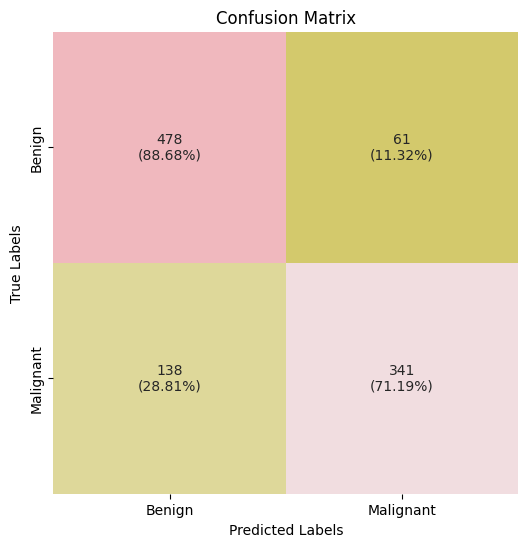

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate row-wise sums
row_sums = conf_matrix.sum(axis=1, keepdims=True)

# Calculate percentages based on row sums
conf_matrix_percent_row = conf_matrix / row_sums * 100

# Create annotations with both count and percentage values
annotations = [f"{conf_matrix[i, j]:d}\n({conf_matrix_percent_row[i, j]:.2f}%)" for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]
annotations = np.array(annotations).reshape(conf_matrix.shape[0], conf_matrix.shape[1])

# Define custom color palette with starting color #6da9ed and ending color #eb6a4d
#colors = sns.diverging_palette(100, 5, s=80, l=60, as_cmap=True)  # 起始颜色为 #6da9ed，结束颜色为 #eb6a4d
colors = sns.diverging_palette(80, 5, s=70, l=80, as_cmap=True)


# Plot confusion matrix with annotations and custom colors
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=annotations, fmt="", cmap=colors, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Add custom labels
plt.xticks(ticks=[0.5, 1.5], labels=["Benign", "Malignant"])
plt.yticks(ticks=[0.5, 1.5], labels=["Benign", "Malignant"])

plt.savefig('confusion_matrix.pdf', dpi=1000)
plt.show()

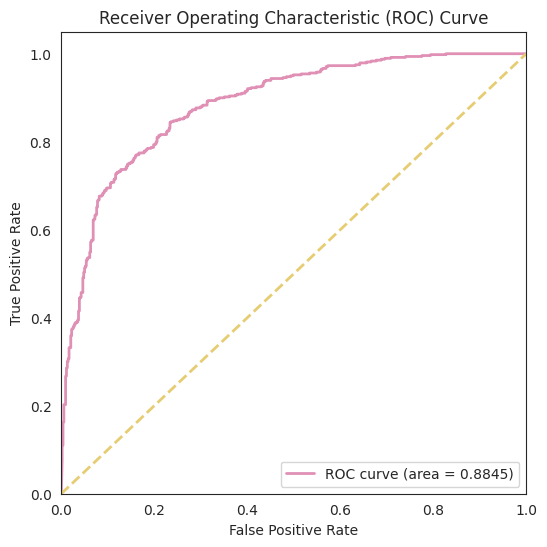

In [28]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Set Seaborn style and color palette
sns.set_style("white")
sns.set_palette(["#e090b5", "#e6cd73"])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot as PDF with 1000dpi
plt.savefig('roc_curve.pdf', dpi=1000)
plt.show()


In [29]:
torch.cuda.empty_cache()

In [30]:
!nvidia-smi

Sun Apr 21 06:30:00 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 44%   61C    P0    45W / 180W |   7884MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------